In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prafullnayan","key":"0bcabf96ae2799c53bdb34294b627af3"}'}

# Upload files

In [4]:
!echo '{"username":"prafullnayan","key":"0bcabf96ae2799c53bdb34294b627af3"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 667M/675M [00:09<00:00, 57.3MB/s]
100% 675M/675M [00:09<00:00, 74.6MB/s]


In [9]:
from zipfile import ZipFile
file_name='cell-images.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [10]:
import pandas as pd

In [11]:
import os

In [12]:
data_dir="/content/cell_images/cell_images"
os.listdir(data_dir)

['Parasitized', 'Uninfected']

In [13]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [14]:
parasitized_image=os.listdir(data_dir+'/Parasitized')
uninfected_image=os.listdir(data_dir+'/Uninfected')

In [15]:
parasitized_image[0:5]

['C180P141NThinF_IMG_20151201_165659_cell_5.png',
 'C48P9thinF_IMG_20150721_162732_cell_6.png',
 'C80P41ThinF_IMG_20150817_110348_cell_129.png',
 'C51AP12thinF_IMG_20150724_160140_cell_69.png',
 'C100P61ThinF_IMG_20150918_145938_cell_175.png']

In [16]:
uninfected_image[0:5]

['C127P88ThinF_IMG_20151004_111220_cell_65.png',
 'C102P63ThinF_IMG_20150918_162051_cell_130.png',
 'C151P112ThinF_IMG_20151115_122342_cell_12.png',
 'C52P13thinF_IMG_20150725_124606_cell_139.png',
 'C48P9thinF_IMG_20150721_160944_cell_192.png']

# Visualizing the images

# 1. Parasitized

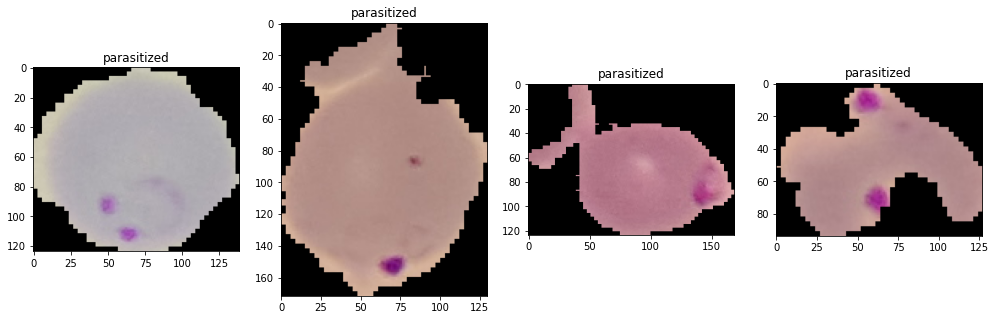

In [17]:
i=1
plt.figure(figsize=(17,14))
for image in parasitized_image[0:4]:
    plt.subplot(1,4,i)
    plt.title('parasitized')
    plt.imshow(imread(data_dir+'/Parasitized/'+image),cmap='gray')
    i=i+1 

# 2.Uninfected

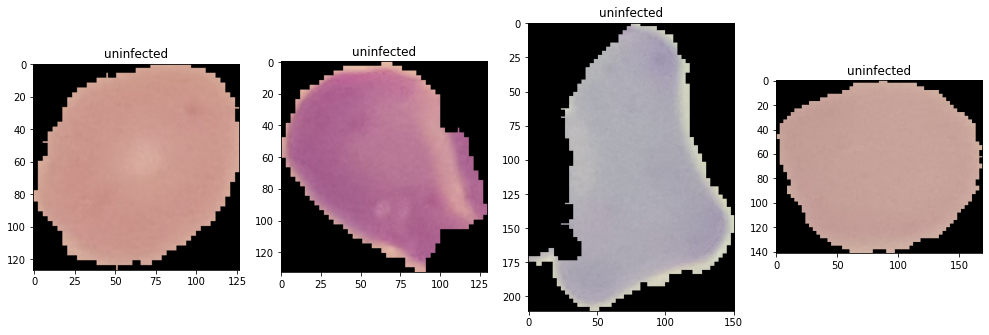

In [18]:
i=1
plt.figure(figsize=(17,14))
for image in uninfected_image[0:4]:
    plt.subplot(1,4,i)
    plt.title('uninfected')
    plt.imshow(imread(data_dir+'/Uninfected/'+image),cmap='gray')
    i=i+1

# Preparing train and test Image Generator

In [19]:
width=128
height=128

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            rescale=1/255,
                            validation_split=0.2)# for dividing into validation data

In [22]:
trainDatagen = datagen.flow_from_directory(directory='/content/cell_images/cell_images',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='training')

Found 22048 images belonging to 2 classes.


In [23]:
testDatagen = datagen.flow_from_directory(directory='/content/cell_images/cell_images',
                                           target_size=(width,height),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='validation')

Found 5510 images belonging to 2 classes.


# Model Building

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D,BatchNormalization,ZeroPadding2D

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(2,2),input_shape=(width,height,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(2,2),input_shape=(width,height,3), activation='relu'))         
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=64, kernel_size=(2,2),input_shape=(width,height,3), activation='relu'))         
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
    
model.add(Dense(128))
model.add(Activation('relu'))
# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [38]:
from keras.optimizers import Adam

In [39]:
optimizer = Adam(lr = 0.0001)

In [40]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

In [41]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
          )

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 64)        16448     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

# Add callbacks

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
early_stop = EarlyStopping(monitor = "val_loss", mode="min", verbose = 2)

In [46]:
trainDatagen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [47]:
import warnings
warnings.filterwarnings('ignore')

# fitting the model

In [49]:
results = model.fit_generator(trainDatagen,epochs=15,
                              validation_data=testDatagen,
                             callbacks=[early_stop])

Epoch 1/15
1378/1378 [==============================] - 119s 86ms/step - loss: 0.6235 - accuracy: 0.6608 - val_loss: 0.5956 - val_accuracy: 0.6936
Epoch 2/15
1378/1378 [==============================] - 119s 86ms/step - loss: 0.4700 - accuracy: 0.8009 - val_loss: 0.3100 - val_accuracy: 0.9067
Epoch 3/15
1378/1378 [==============================] - 119s 87ms/step - loss: 0.2888 - accuracy: 0.9000 - val_loss: 0.2297 - val_accuracy: 0.9211
Epoch 4/15
1378/1378 [==============================] - 120s 87ms/step - loss: 0.2271 - accuracy: 0.9217 - val_loss: 0.2219 - val_accuracy: 0.9278
Epoch 5/15
1378/1378 [==============================] - 117s 85ms/step - loss: 0.2149 - accuracy: 0.9269 - val_loss: 0.2052 - val_accuracy: 0.9309
Epoch 6/15
1378/1378 [==============================] - 116s 84ms/step - loss: 0.2021 - accuracy: 0.9333 - val_loss: 0.1854 - val_accuracy: 0.9318
Epoch 7/15
1378/1378 [==============================] - 115s 83ms/step - loss: 0.1931 - accuracy: 0.9396 - val_loss: 0

# Evaluating the model

In [65]:
loss,accuracy=model.evaluate_generator(testDatagen)

In [68]:
print(f"for the given model loss is {loss:{0.3}} and accuracy is {accuracy:{0.3}}")

for the given model loss is 0.189 and accuracy is 0.933


# saving the model

In [69]:
from tensorflow.keras.models import load_model

In [70]:
model.save('malaria_prediction.h5')